In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import math


In [2]:
def expected_calibration_error(probs, labels, n_bins=10):
    """Compute ECE (binning method). probs are predicted positive probabilities."""
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs > lo) & (probs <= hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        avg_prob = probs[mask].mean()
        avg_true = labels[mask].mean()
        ece += (mask.sum() / probs.shape[0]) * abs(avg_prob - avg_true)
    return ece

def plot_reliability(probs_list, labels, labels_names, n_bins=10):
    """Plot reliability diagram for multiple methods."""
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1], '--', color='gray')
    for probs, name in zip(probs_list, labels_names):
        fraction_of_positives, mean_predicted_value = calibration_curve(labels, probs, n_bins=n_bins)
        plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"{name} (ECE={expected_calibration_error(probs, labels, n_bins):.3f})")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Reliability diagram")
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
def platt_scaling_train(scores_calib, y_calib):
    """Fit logistic regression on raw model scores to get Platt scaling."""
    # Scores should be 1D. Fit a logistic regression (no penalty) with intercept.
    lr = LogisticRegression(solver='lbfgs', C=1e6, max_iter=200)
    lr.fit(scores_calib.reshape(-1,1), y_calib)
    return lr

def platt_predict(lr, scores):
    prob = lr.predict_proba(scores.reshape(-1,1))[:,1]
    return prob

def isotonic_calibration_train(scores_calib, y_calib, out_of_bounds='clip'):
    ir = IsotonicRegression(out_of_bounds=out_of_bounds, y_min=0.0, y_max=1.0)
    ir.fit(scores_calib, y_calib)
    return ir

def isotonic_predict(ir, scores):
    return ir.predict(scores)


In [4]:
def split_conformal_train(X_train, y_train, X_calib, y_calib, model_cls=RandomForestRegressor, **model_kwargs):
    """
    Train model on X_train/y_train, compute calibration residuals on X_calib/y_calib.
    Return model and array of absolute residuals on calibration set.
    """
    model = model_cls(**model_kwargs)
    model.fit(X_train, y_train)
    preds_calib = model.predict(X_calib)
    residuals = np.abs(y_calib - preds_calib)
    return model, residuals

def split_conformal_predict_intervals(model, residuals, X_test, alpha=0.05):
    """
    Compute (1-alpha) conformal prediction intervals using quantile of residuals.
    Returns (lower, upper) arrays.
    """
    q = np.quantile(residuals, 1 - alpha)  # use 1-alpha for two-sided; this is basic split conformal
    preds = model.predict(X_test)
    lower = preds - q
    upper = preds + q
    return lower, upper, q

In [5]:
def example_classification():
    # synthetic binary classification
    X, y = make_classification(n_samples=5000, n_features=20, n_informative=10, random_state=42)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=1)
    X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2)

    # Uncalibrated classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    # raw scores (use decision_function if available; we use predict_proba second column)
    raw_probs = clf.predict_proba(X_test)[:,1]
    raw_scores_calib = clf.predict_proba(X_calib)[:,1]  # use prob as 'score' — for tree ensembles it is already a prob but can still be calibrated
    raw_scores_test = clf.predict_proba(X_test)[:,1]

    # For demonstration of Platt scaling, pretend the model outputs a "score" that is uncalibrated:
    # We'll use the classifier's predicted logit-like score via logit transform (avoid extremes)
    eps = 1e-6
    def prob_to_score(p):
        p = np.clip(p, eps, 1-eps)
        return np.log(p/(1-p))
    scores_calib = prob_to_score(raw_scores_calib)
    scores_test = prob_to_score(raw_scores_test)

    # Platt
    platt = platt_scaling_train(scores_calib, y_calib)
    platt_probs = platt_predict(platt, scores_test)

    # Isotonic
    iso = isotonic_calibration_train(scores_calib, y_calib)
    iso_probs = isotonic_predict(iso, scores_test)

    # Uncalibrated (raw_probs) and calibrated versions
    methods_probs = [raw_probs, platt_probs, iso_probs]
    names = ["Uncalibrated", "Platt (sigmoid)", "Isotonic"]

    # Reliability diagram + ECEs
    plot_reliability(methods_probs, y_test, names, n_bins=10)

    # Show Brier scores
    for probs, name in zip(methods_probs, names):
        print(f"{name}: Brier={brier_score_loss(y_test, probs):.4f}, ECE={expected_calibration_error(probs, y_test, n_bins=10):.4f}")



In [6]:
def example_regression():
    # synthetic regression
    X, y = make_regression(n_samples=2000, n_features=10, noise=10.0, random_state=0)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=1)
    X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2)

    # Train with split-conformal
    model, residuals = split_conformal_train(X_train, y_train, X_calib, y_calib, model_cls=RandomForestRegressor, n_estimators=200, random_state=0)

    alphas = [0.05, 0.1, 0.2]  # target error rates -> intervals: 95%, 90%, 80%
    coverages = []
    widths = []
    for alpha in alphas:
        lower, upper, q = split_conformal_predict_intervals(model, residuals, X_test, alpha=alpha)
        coverage = np.mean((y_test >= lower) & (y_test <= upper))
        avg_width = np.mean(upper - lower)
        coverages.append(coverage)
        widths.append(avg_width)
        print(f"alpha={alpha:.2f} -> nominal coverage={(1-alpha):.2f}, empirical coverage={coverage:.3f}, avg width={avg_width:.3f}, q={q:.3f}")

    # Plot coverage vs nominal
    plt.figure()
    nominal = [1-a for a in alphas]
    plt.plot(nominal, coverages, marker='o')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("Nominal coverage")
    plt.ylabel("Empirical coverage")
    plt.title("Split-conformal: empirical vs nominal coverage")
    plt.grid(True)
    plt.show()


Running classification example...


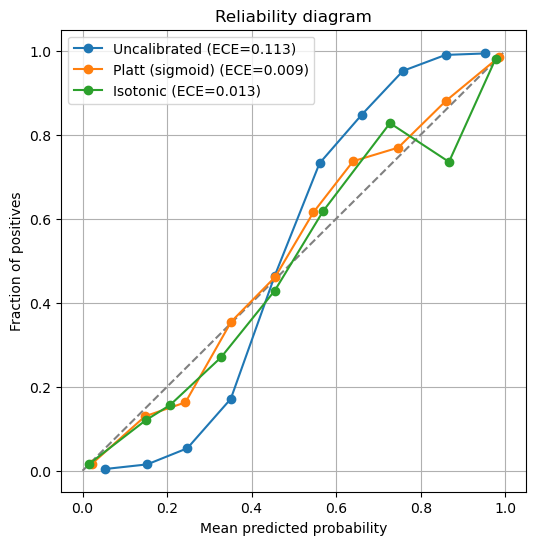

Uncalibrated: Brier=0.0623, ECE=0.1130
Platt (sigmoid): Brier=0.0448, ECE=0.0093
Isotonic: Brier=0.0460, ECE=0.0130

Running regression (split-conformal) example...
alpha=0.05 -> nominal coverage=0.95, empirical coverage=0.946, avg width=381.783, q=190.892
alpha=0.10 -> nominal coverage=0.90, empirical coverage=0.910, avg width=326.078, q=163.039
alpha=0.20 -> nominal coverage=0.80, empirical coverage=0.842, avg width=254.155, q=127.077


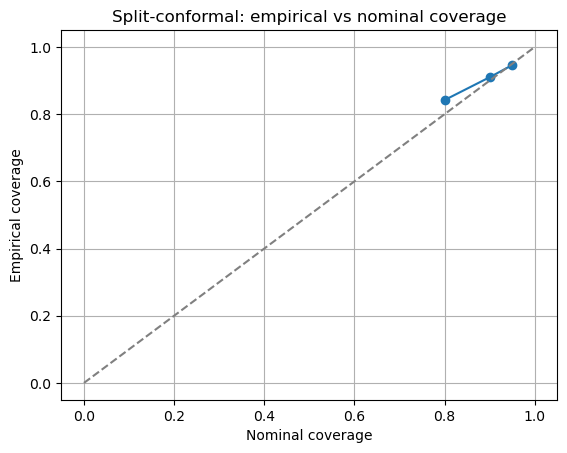

In [7]:
if __name__ == "__main__":
    print("Running classification example...")
    example_classification()
    print("\nRunning regression (split-conformal) example...")
    example_regression()